In [30]:
import numpy as np
from numba import njit

def get_mean_time(M, fundamental_matrix):
    c = np.ones(fundamental_matrix.shape[0])
    mean_times = fundamental_matrix @ c
    return mean_times[M * (M // 2) + M // 2]

def get_fundamental_matrix(Q):
    return np.linalg.inv(np.eye(Q.shape[0]) - Q)

@njit
def make_prob_matrix(M, strategy_center, strategy_border):
    probabilities = np.zeros((M ** 2, M ** 2))
    for x in range(0, M):
        for y in range(0, M):
            pc = strategy_center[x, y]
            pb = strategy_border[x, y]
            if y + 1 < M:
                probabilities[M * x + y, M * (x + 0) + (y + 1)] = (1 - pc) * pb
            if y - 1 >= 0:
                probabilities[M * x + y, M * (x + 0) + (y - 1)] = pc * pb
            if x + 1 < M:
                probabilities[M * x + y, M * (x + 1) + (y + 0)] = pc * (1 - pb)
            if x - 1 >= 0:
                probabilities[M * x + y, M * (x - 1) + (y + 0)] = (1 - pc) * (1 - pb)
    
    return probabilities

def objective_function(strategy_center, strategy_border, M):
    probability_matrix = make_prob_matrix(M, strategy_center, strategy_border)
    fundamental_matrix = get_fundamental_matrix(probability_matrix)
    mean_time = get_mean_time(M, fundamental_matrix)
    return mean_time

def objective_function_1d(strategy_center_1d, strategy_border_1d, M):
    return objective_function(np.reshape(strategy_center_1d, (M, M)), np.reshape(strategy_border_1d, (M, M)), M)
    

'''
Problem:
max by strategy_center
    min by strategy_border
        objective_function(strategy_center, strategy_border)
N = const = 16 - the size of problem
'''

N = 4
M = N - 1

strategy_center = np.ones ((M, M), dtype=np.float64) * 0.5
strategy_border = np.ones ((M, M), dtype=np.float64) * 0.5

# 75.20846497681381
print(objective_function(strategy_center, strategy_border, M))

4.5


In [33]:
from scipy.optimize import minimize
from tqdm.notebook import tqdm
from functools import partial

def step_optimize(res, func, progress):
    f = func(res)
    progress.set_description(f"{-f:0.5f}")
    progress.update(1)


def max_objective(strategy_border, M):
    x0 = strategy_center
    #progress = tqdm(mininterval=1)
    try:
        def max_func(x):
            return -objective_function(np.reshape(x, (M, M)), strategy_border, M)
        bounds = [(0.2, 0.8) for i in range(M * M)]
        res = minimize(max_func, x0, bounds=bounds, method='Nelder-Mead', tol=1e-6)
        #, callback=partial(step_optimize, func=max_func, progress=progress)
    finally:
        #progress.close()
        pass
    return -res.fun

def min_objective(strategy_center, M):
    x0 = strategy_border
    #progress = tqdm(mininterval=1)
    try:
        def min_func(x):
            return objective_function(strategy_center, np.reshape(x, (M, M)), M)
        bounds = [(0.2, 0.8) for i in range(M * M)]
        res = minimize(min_func, x0, bounds=bounds, method='Nelder-Mead', tol=1e-6)
        #, callback=partial(step_optimize, func=min_func, progress=progress)
    finally:
        #progress.close()
        pass
    return res.fun

def min_dist():
    x0 = np.concatenate([strategy_center.reshape(1, -1), strategy_border.reshape(1, -1)])
    progress = tqdm(mininterval=1)
    try:
        def min_max_fun(x):
            strategy_center = np.reshape(x[:M * M], (M, M))
            strategy_border = np.reshape(x[-M * M:], (M, M))
            return max_objective(strategy_border, M) - min_objective(strategy_center, M)
        bounds = [(0.2, 0.8) for i in range(2 * M * M)]
        res = minimize(min_max_fun, x0, bounds=bounds, method='Nelder-Mead', tol=1e-6, callback=partial(step_optimize, func=min_max_fun, progress=progress))
    finally:
        progress.close()
    return res
res = min_dist()
#max_objective(strategy_border, M)
#min_objective(strategy_center, M)
#res = minimize(lambda x: objective_function(x[0], x[1], M), x0, method='Nelder-Mead', tol=1e-6)

0it [00:00, ?it/s]

<AxesSubplot:>

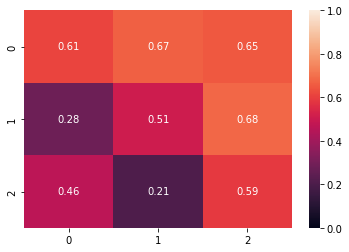

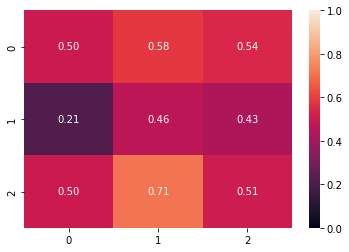

In [39]:
strategy_center = np.reshape(res.x[:M * M], (M, M))
strategy_border = np.reshape(res.x[-M * M:], (M, M))
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure()
sns.heatmap(strategy_center, annot=True, fmt="0.2f", vmin=0, vmax=1)

plt.figure()
sns.heatmap(strategy_border, annot=True, fmt="0.2f", vmin=0, vmax=1)

In [21]:
import numpy as np
from PvP_min_max_symm_objective import objective_function
N = 4
M = N - 1
dtype = np.float64
cnt = (M ** 2 - 1) // 4 - M // 2

strategy_center_flat = np.ones(cnt, dtype=dtype) * 0.5
strategy_border_flat = np.ones(cnt, dtype=dtype) * 0.5

def objective_function_except(*arg, **argw):
    try:
        fun = objective_function(*arg, **argw)
        if np.isnan(fun):
            print()
            print('BUG NAN!!!')
            print(arg, argw) 
            print(fun)
            print()
        return fun
    except Exception as e:
        print('BUG2!!!')
        print(e)
        print(arg, argw)
        return np.nan


from scipy.optimize import minimize
from tqdm.notebook import tqdm
from functools import partial

def step_optimize(res, func, progress=None):
    if not progress is None:
        f, mn, mx = func(res, need_all=True)
        progress.set_description(f"{f:0.5f} | mn = {mn:0.5f} | mx = {mx:0.5f}")
        progress.update(1)


progress_inner = tqdm(mininterval=1)

bound = (0.1, 0.9)

def max_objective(strategy_center_0, strategy_border, M):
    x0 = strategy_center_0
    #try:
    def max_func(x):
        return -objective_function_except(x, strategy_border, M)
    bounds = [bound for i in range(len(x0))]
    res = minimize(max_func, x0, bounds=bounds, method='Nelder-Mead', tol=1e-6, options={'maxiter':1000})
    if np.isnan(res.fun):
        fun = max_func(res.x)
        if np.isnan(fun):
            print(fun, res.x, M)
        res.fun = fun
    if np.isnan(res.fun):
        print('Max BUG!!!!!!!')
        print(res.x, strategy_border)
    #, callback=partial(step_optimize, func=max_func, progress=progress_inner)
    #finally:
        #progress.close()
    return res.fun, res

def min_objective(strategy_center, strategy_border_0, M):
    x0 = strategy_border_0
    #progress = tqdm(mininterval=1)
    #try:
    def min_func(x):
        return objective_function_except(strategy_center, x, M)
    bounds = [bound for i in range(len(x0))]
    res = minimize(min_func, x0, bounds=bounds, method='Nelder-Mead', tol=1e-6, options={'maxiter':1000})
    if np.isnan(res.fun):
        res.fun = min_func(res.x)
    if np.isnan(res.fun):
        print('Min BUG!!!!!!!')
        print(strategy_center, res.x)
    #, callback=partial(step_optimize, func=min_func, progress=progress)
    #finally:
    #    progress.close()
    return res.fun, res

def min_dist(strategy_center_flat, strategy_border_flat):
    x0 = np.concatenate([strategy_center_flat, strategy_border_flat])
    progress = tqdm(mininterval=1)
    try:
        def min_max_fun(x, need_all=False):
            strategy_center = x[:cnt]
            strategy_border = x[-cnt:]
            #mx, res1 = max_objective(strategy_border, M)
            #mn, res2 = min_objective(strategy_center, M)

            mx, res1 = random_search(max_objective, M, num_iter=10, strategy_center=None, strategy_border=strategy_border)
            mn, res2 = random_search(min_objective, M, num_iter=10, strategy_center=strategy_center, strategy_border=None)

            print()
            print('#' * 20)
            print(strategy_border)
            print(res1)
            print(strategy_center)
            print(res2)
            print(mx - mn, mn, mx)
            if need_all:
                return -mx - mn, mn, mx
            else:
                return -mx - mn
        bounds = [bound for i in range(len(x0))]
        res = minimize(min_max_fun, x0, bounds=bounds, method='Powell', #Nelder-Mead
                        tol=1e-10, options={'maxiter':10000}, callback=partial(step_optimize, func=min_max_fun, progress=progress))
        if np.isnan(res.fun):
            res.fun = min_max_fun(res.x)
    finally:
        progress.close()
    return res

def random_search(opt_func, M, num_iter=100, strategy_center=None, strategy_border=None):
    ans = None
    for i in range(num_iter):
        if strategy_center is None:
            strategy_center_0 = np.random.uniform(low=bound[0], high=bound[1], size=cnt)
        else:
            strategy_center_0 = strategy_center
        if strategy_border is None:
            strategy_border_0 = np.random.uniform(low=bound[0], high=bound[1], size=cnt)
        else:
            strategy_border_0 = strategy_border
        val, res = opt_func(strategy_center_0, strategy_border_0, M)
        #print(strategy_center_0, strategy_border_0, val)
        if ans is None:
            ans = res
        elif ans.fun > res.fun:
            ans = res
    return ans.fun, ans


def random_search_all(num_iter):
    ans = None
    for i in range(num_iter):
        strategy_center_flat = np.random.uniform(low=bound[0], high=bound[1], size=cnt)
        strategy_border_flat = np.random.uniform(low=bound[0], high=bound[1], size=cnt)
        res = min_dist(strategy_center_flat, strategy_border_flat)
        if ans is None:
            ans = res
        elif ans.fun > res.fun:
            ans = res
    return ans

random_search_all(num_iter=1)
#max_objective(strategy_border, M)
#min_objective(strategy_center, M)
#res = minimize(lambda x: objective_function(x[0], x[1], M), x0, method='Nelder-Mead', tol=1e-6)

0it [00:00, ?it/s]

0it [00:00, ?it/s]


####################
[0.59617288]
 final_simplex: (array([[0.1],
       [0.1]]), array([-9.04005473, -9.04005473]))
           fun: -9.04005473052662
       message: 'Optimization terminated successfully.'
          nfev: 12
           nit: 6
        status: 0
       success: True
             x: array([0.1])
[0.37775405]
 final_simplex: (array([[0.1],
       [0.1]]), array([4.7700858, 4.7700858]))
           fun: 4.770085804109339
       message: 'Optimization terminated successfully.'
          nfev: 8
           nit: 4
        status: 0
       success: True
             x: array([0.1])
-13.81014053463596 4.770085804109339 -9.04005473052662

####################
[0.59617288]
 final_simplex: (array([[0.1],
       [0.1]]), array([-9.04005473, -9.04005473]))
           fun: -9.04005473052662
       message: 'Optimization terminated successfully.'
          nfev: 10
           nit: 5
        status: 0
       success: True
             x: array([0.1])
[0.40557281]
 final_simplex: (array(

   direc: array([[ 0.00000000e+00,  1.00000000e+00],
       [ 6.24783995e-12, -2.61560857e-12]])
     fun: 1.0376622905600277
 message: 'Optimization terminated successfully.'
    nfev: 565
     nit: 5
  status: 0
 success: True
       x: array([0.35311359, 0.29843788])

In [22]:
BUG NAN!!!
(array([0.67962032]), array([0.29843788]), 3) {}
nan

3

In [14]:
min_dist(np.array([0.29872247]), np.array([0.29872247]))

0it [00:00, ?it/s]


####################
[0.29872247]
 final_simplex: (array([[0.1],
       [0.1]]), array([-6.70312372, -6.70312372]))
           fun: -6.703123721516575
       message: 'Optimization terminated successfully.'
          nfev: 12
           nit: 6
        status: 0
       success: True
             x: array([0.1])
[0.29872247]
 final_simplex: (array([[0.1],
       [0.1]]), array([5.62733369, 5.62733369]))
           fun: 5.627333690076885
       message: 'Optimization terminated successfully.'
          nfev: 12
           nit: 6
        status: 0
       success: True
             x: array([0.1])
-12.33045741159346 5.627333690076885 -6.703123721516575

####################
[0.29872247]
 final_simplex: (array([[0.1],
       [0.1]]), array([-6.70312372, -6.70312372]))
           fun: -6.703123721516575
       message: 'Optimization terminated successfully.'
          nfev: 12
           nit: 6
        status: 0
       success: True
             x: array([0.1])
[0.40557281]
 final_simplex: (

   direc: array([[0.00000000e+00, 1.00000000e+00],
       [1.79273708e-11, 9.21593368e-18]])
     fun: 1.0376622906793163
 message: 'Optimization terminated successfully.'
    nfev: 390
     nit: 3
  status: 0
 success: True
       x: array([0.35311359, 0.29843788])

In [23]:
objective_function_except(np.array([0.67962032]), np.array([0.29843788]), 3)

6.701562133543912

In [166]:
min_objective(strategy_center=np.array([0.29872247]), strategy_border_0=np.array([0.29872247]), M=M)
max_objective(strategy_center_0=np.array([0.29872247]), strategy_border=np.array([0.29872247]), M=M)

(-6.703123721516575,
  final_simplex: (array([[0.1],
        [0.1]]), array([-6.70312372, -6.70312372]))
            fun: -6.703123721516575
        message: 'Optimization terminated successfully.'
           nfev: 10
            nit: 5
         status: 0
        success: True
              x: array([0.1]))

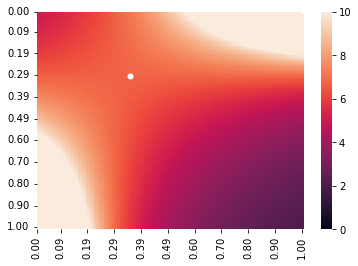

In [151]:
from PvP_min_max_symm_objective import objective_function

x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
f = np.zeros((100, 100))
for i in range(len(x)):
    for j in range(len(y)):
        try:
            f[i, j] = objective_function(np.array([y[j]]), np.array([x[i]]), M)
        except:
            f[i, j] = np.nan

num_ticks = 11
yticks = np.linspace(0, len(y) - 1, num_ticks, dtype=int)
yticklabels = [f'{y[idx]:0.2f}' for idx in yticks]
xticks = np.linspace(0, len(x) - 1, num_ticks, dtype=int)
xticklabels = [f'{x[idx]:0.2f}' for idx in xticks]

ax = sns.heatmap(f, vmin=0, vmax=10)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.set_xticklabels(xticklabels)
ax.set_yticklabels(yticklabels)

ax.scatter(0.35311359 * (len(x) - 1), 0.29843788 * (len(y) - 1), marker='.', s=100, color='white') 
pass

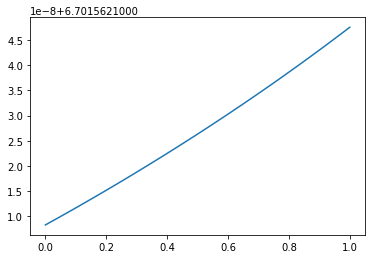

In [120]:
x = np.linspace(0, 1, 100)
y = 0.29843788
f = np.zeros(100)
for i in range(len(x)):
    try:
        f[i] = objective_function(np.array([y]), np.array([x[i]]), M)
    except:
        f[i] = np.nan

plt.plot(x, f)


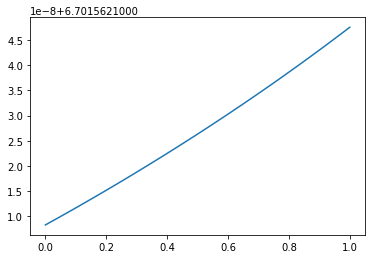

In [150]:
y = np.linspace(0, 1, 100)
x = 0.35311359
x = 0.29843788
f = np.zeros(100)
for i in range(len(y)):
    try:
        f[i] = objective_function(np.array([y[i]]), np.array([x]), M)
    except:
        f[i] = np.nan

plt.plot(y, f)
